<a href="https://colab.research.google.com/github/Javsk891/Modelaci-n-tasas-de-cambio/blob/main/Modelaci%C3%B3n_tasa_de_cambio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Taller Modelación Tasa de Cambio**



# **Fase 1: Modelación del retorno de la tasa de cambio USD/CAD mediante modelos de la familia GARCH**

Este código se centra en la implementación del modelo GARCH para pronosticar la volatilidad del dólar canadiense en relación con el dólar estadounidense. El enfoque GARCH permite capturar la naturaleza dinámica de la volatilidad, considerando la autocorrelación y la heterocedasticidad condicional de los rendimientos del tipo de cambio.

A través de este código, exploraremos cómo utilizar el método GARCH para analizar y anticipar la volatilidad del par de divisas USD/CAD, brindando así información valiosa para la toma de decisiones en los mercados financieros.

In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 11.2 MB/s eta 0:00:00


In [ ]:
pip install sgt

In [ ]:
import pickle
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from statsmodels.compat import lzip
import statsmodels.api as sm
import pandas as pd
import numpy as np
from arch import arch_model
import sgt
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.holtwinters as holtwinters
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats


import seaborn as sns
import matplotlib.pyplot as plt

### **Extract, transform, and load (ETL)**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Carga el archivo CSV
data = pd.read_csv("/content/gdrive/My Drive/usdcad.csv",sep=";", encoding='latin1')
data

,Dates,usdcad
0,05/03/2020,"1,3411"
1,06/03/2020,"1,3418"
2,09/03/2020,"1,3702"
3,10/03/2020,"1,3727"
4,11/03/2020,"1,3779"
...,...,...
1062,01/04/2024,"1,357"
1063,02/04/2024,"1,3567"
1064,03/04/2024,"1,3527"
1065,04/04/2024,"1,3543"


In [ ]:
# Reemplazar las comas por puntos en la columna usdcad
data['usdcad'] = data['usdcad'].str.replace(',', '.')
# Convertir la columna a tipo float
data['usdcad'] = data['usdcad'].astype(float)

Puesto que por defecto Python toma como separador decimales'.' y nuestra datos aparece, por ',' reemplazamos como (',') por punto ('.')

In [ ]:
data

,Dates,usdcad
0,05/03/2020,1.3411
1,06/03/2020,1.3418
2,09/03/2020,1.3702
3,10/03/2020,1.3727
4,11/03/2020,1.3779
...,...,...
1062,01/04/2024,1.3570
1063,02/04/2024,1.3567
1064,03/04/2024,1.3527
1065,04/04/2024,1.3543


In [ ]:
# Convertir la columna 'usdcad' a una serie de tiempo
datats1 = pd.Series(data['usdcad'])
# Convertir la columna 'Dates' al formato de fecha correcto
datats2 = pd.to_datetime(data['Dates'], format='%d/%m/%Y')

# Mostrar las primeras filas de la serie de tiempo para verificar
print(datats1.head())

0    1.3411
1    1.3418
2    1.3702
3    1.3727
4    1.3779
Name: usdcad, dtype: float64


## **Análisis Exploratorio (EDA)**

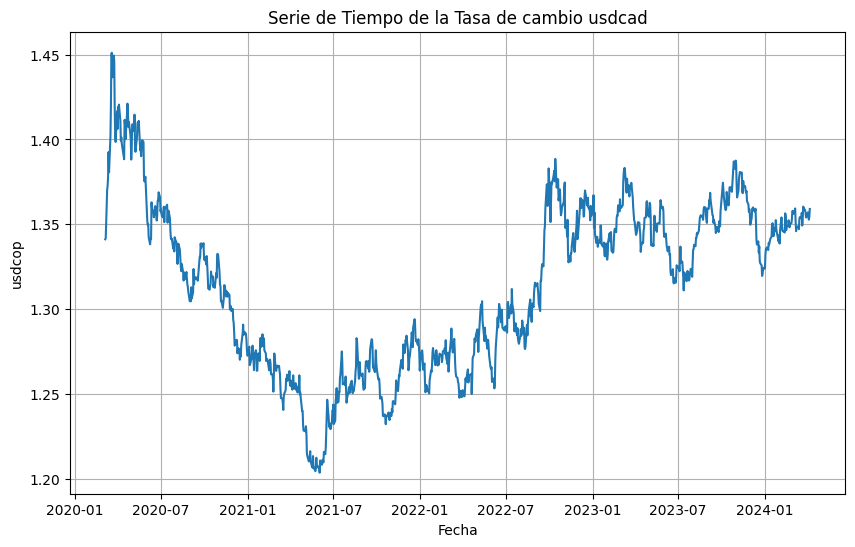

In [ ]:
# Graficar la serie de tiempo con fechas en el eje x
plt.figure(figsize=(10, 6))
plt.plot(datats2, datats1)
plt.title('Serie de Tiempo de la Tasa de cambio USD/CAD')
plt.xlabel('Fecha')
plt.ylabel('USD/CAD')
plt.grid(True)
plt.show()

La gráfica que muestra la serie de tiempo de la tasa de cambio USD/CAD nos permite observar la volatilidad del dólar canadiense respecto al dólar estadounidense durante los últimos años. La tasa de cambio USD/CAD ha experimentado una tendencia a la baja. Esto significa que el dólar canadiense se ha apreciado frente al dólar estadounidense en las últimas dos décadas.

En 2020 la tasa de cambio se desplomó a un mínimo histórico de 1,20 USD/CAD debido a la pandemia de COVID-19. Sin embargo, la tasa de cambio se recuperó rápidamente en 2021 y 2022, alcanzando un máximo de 1,45 USD/CAD en febrero de 2022.

In [ ]:
# Calcula la media móvil y la desviación estándar móvil
rolling_mean = datats1.rolling(4).mean()
rolling_std = datats1.rolling(4).std()
rolling_std

0            NaN
1            NaN
2            NaN
3       0.017353
4       0.016220
          ...   
1062    0.001676
1063    0.001650
1064    0.002093
1065    0.002045
1066    0.002760
Name: usdcad, Length: 1067, dtype: float64

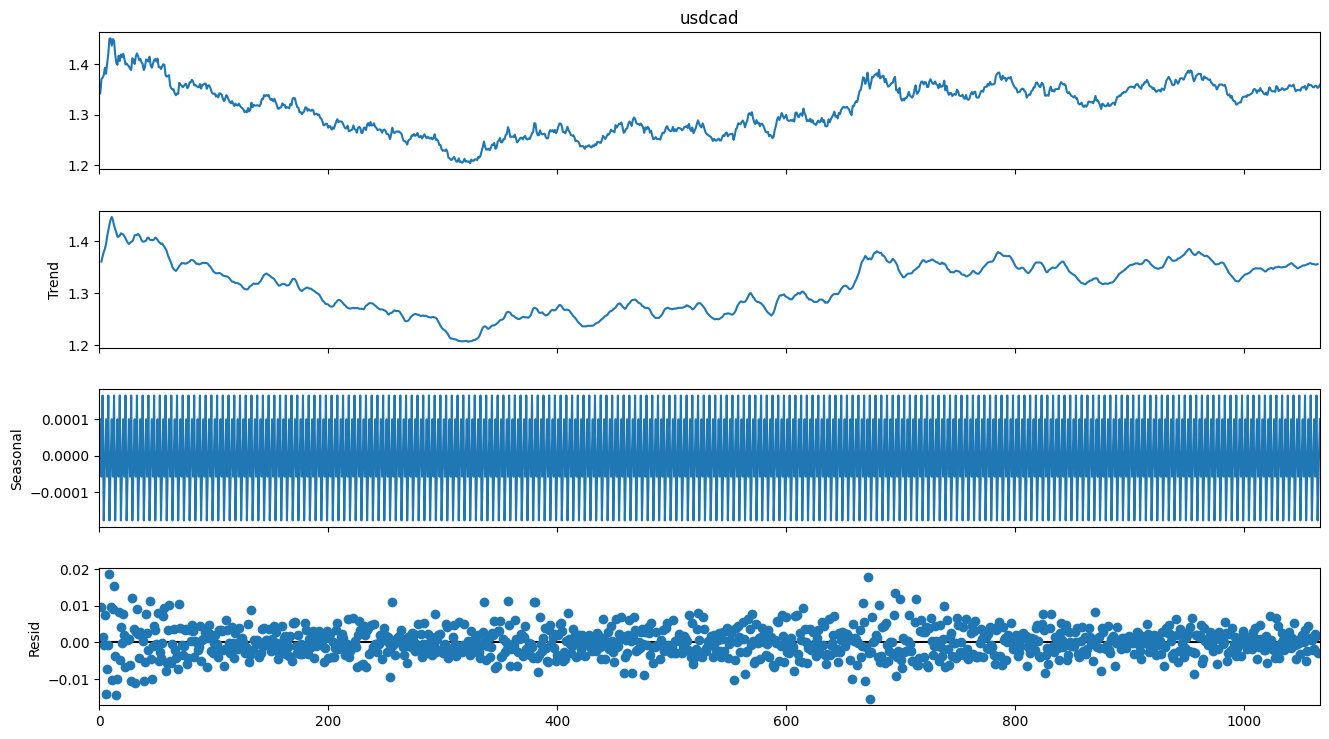

In [ ]:
# Realizar la descomposición estacional
decomp = sm.tsa.seasonal_decompose(datats1, period=5)  # Período establecido en 7 días

# Trazar los componentes de la descomposición
fig = decomp.plot()
fig.set_size_inches(15, 8)
plt.show()

La gráfica "Trend" muestra la volatilidad estacional de la tasa de cambio USD/CAD. La volatilidad estacional es la variación de la tasa de cambio

La gráfica "Resid" muestra la volatilidad residual de la tasa de cambio USD/CAD. La volatilidad residual es la diferencia entre la tasa de cambio observada y la tasa de cambio que se esperaría en función de los modelos econométricos.

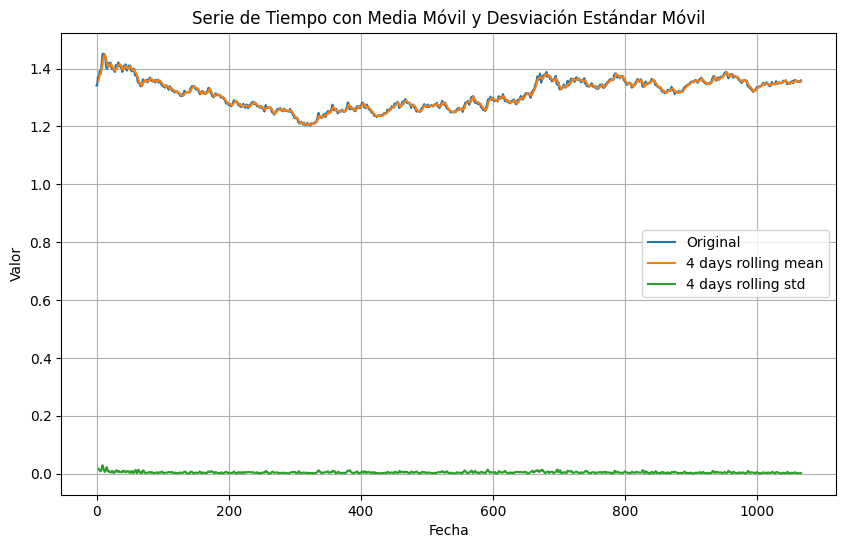

In [ ]:
# Grafica la serie de tiempo original y las medias móviles
plt.figure(figsize=(10, 6))
datats1.plot(label='Original')
rolling_mean.plot(label='4 days rolling mean')
rolling_std.plot(label='4 days rolling std')
plt.title('Serie de Tiempo con Media Móvil y Desviación Estándar Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

Estacionariedad

En esta sección, verificamos la estacionariedad de la serie y la transformamos a estacionaria si resulta ser no estacionaria. Para esto, se define a continuación una función auxiliar que traza los gráficos ACF y PACF de la serie que se le proporciona como entrada.

In [ ]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, zero = False, lags = 40, ax = axes[0])
    sgt.plot_pacf(series, zero = False, lags = 40, ax = axes[1])

    plt.show()

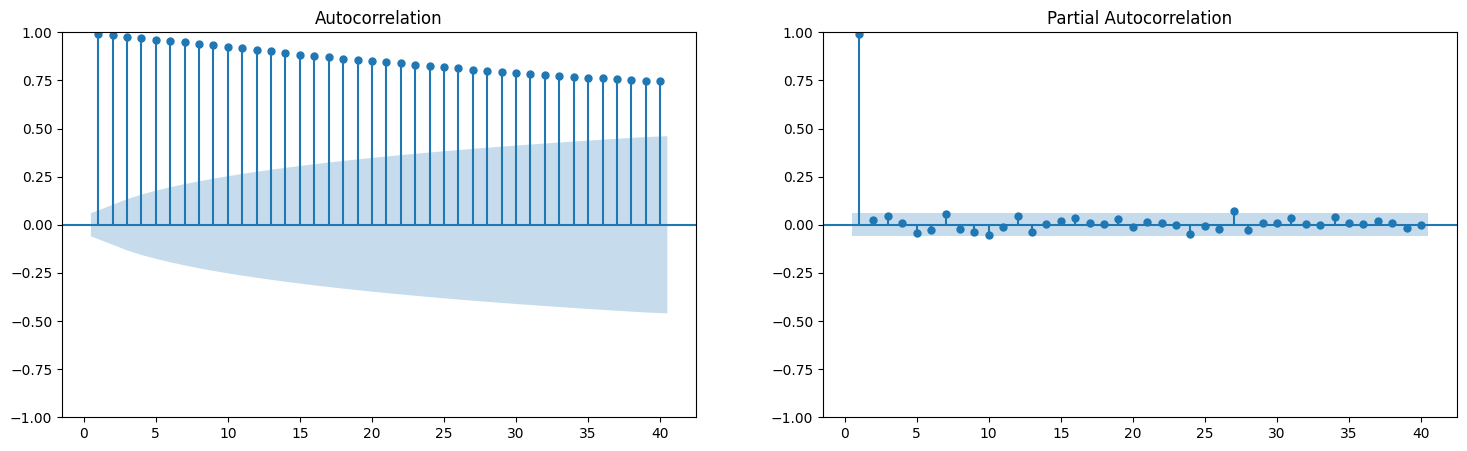

In [ ]:
plot_acf_pacf(data['usdcad'])

Probamos los test Dickey-Fuller y KPSS para saber si hay estacionariedad

In [ ]:
result = adfuller(data['usdcad'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")

ADF Statistic: -1.8897215416650566
p-value: 0.3369117636929552
Critical Values: {'1%': -3.436510851955201, '5%': -2.864260220574562, '10%': -2.5682183458999943}
La serie no es estacionaria.


In [ ]:
result = kpss(data['usdcad'])

print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

if result[1] <= 0.05:
    print("La serie no es estacionaria.")
else:
    print("La serie es estacionaria.")

KPSS Statistic: 1.4145453517726831
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie no es estacionaria.


<ipython-input-18-1aa3b9e1fc38>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data['usdcad'])


 Dado que la serie no es estacionaria vamos aplicar diferencias y transformación logaritmica

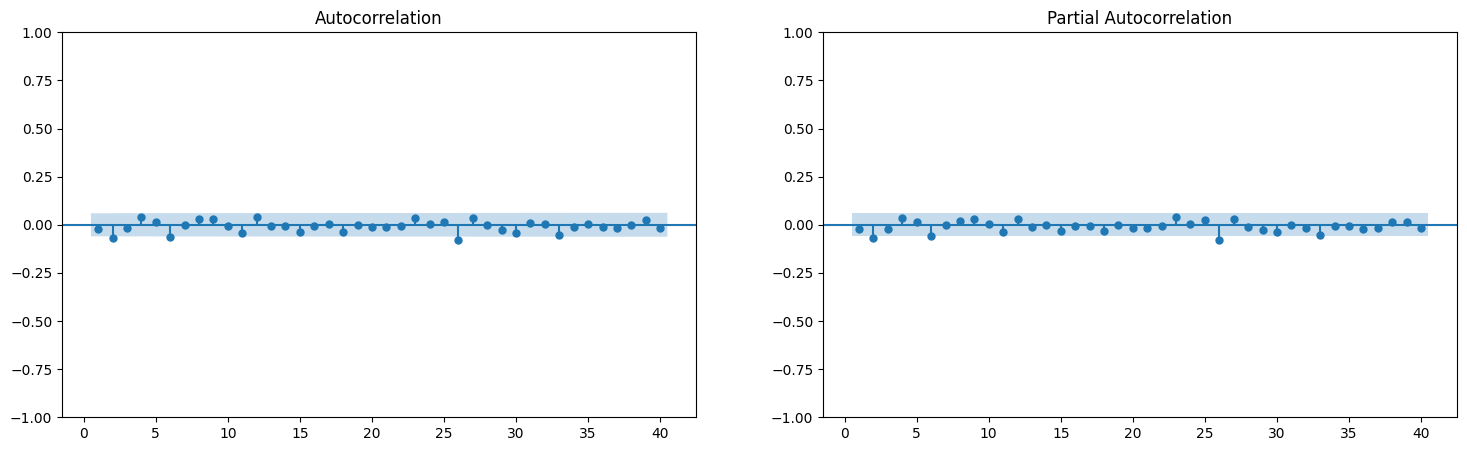

In [ ]:
plot_acf_pacf(data["usdcad"].diff(1).dropna())

In [ ]:
result = adfuller(data['usdcad'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")

ADF Statistic: -1.8897215416650566
p-value: 0.3369117636929552
Critical Values: {'1%': -3.436510851955201, '5%': -2.864260220574562, '10%': -2.5682183458999943}
La serie no es estacionaria.


In [ ]:
log_trans_data = np.log(data["usdcad"])

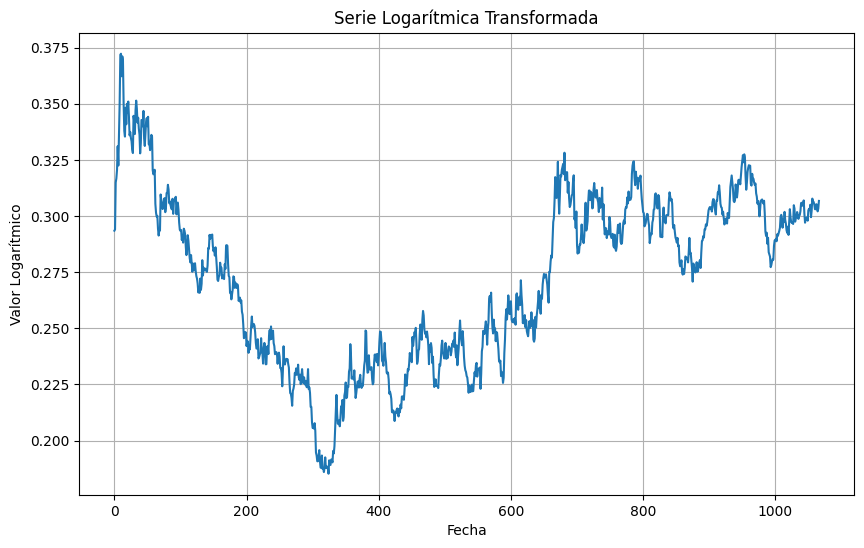

In [ ]:
log_trans_data = np.log(data["usdcad"])

# Graficar la serie logarítmica transformada
plt.figure(figsize=(10, 6))
plt.plot(log_trans_data)
plt.title('Serie Logarítmica Transformada')
plt.xlabel('Fecha')
plt.ylabel('Valor Logarítmico')
plt.grid(True)
plt.show()


In [ ]:
result = adfuller(log_trans_data)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")

ADF Statistic: -1.8627526200608981
p-value: 0.34978111082948304
Critical Values: {'1%': -3.436510851955201, '5%': -2.864260220574562, '10%': -2.5682183458999943}
La serie no es estacionaria.


Después de usar transformación logaritmica, y usar el test Dickey-Fuller la serie no es estacionaria, sin embargo, el gráfica no muestra mucha varianza en el tiempo.

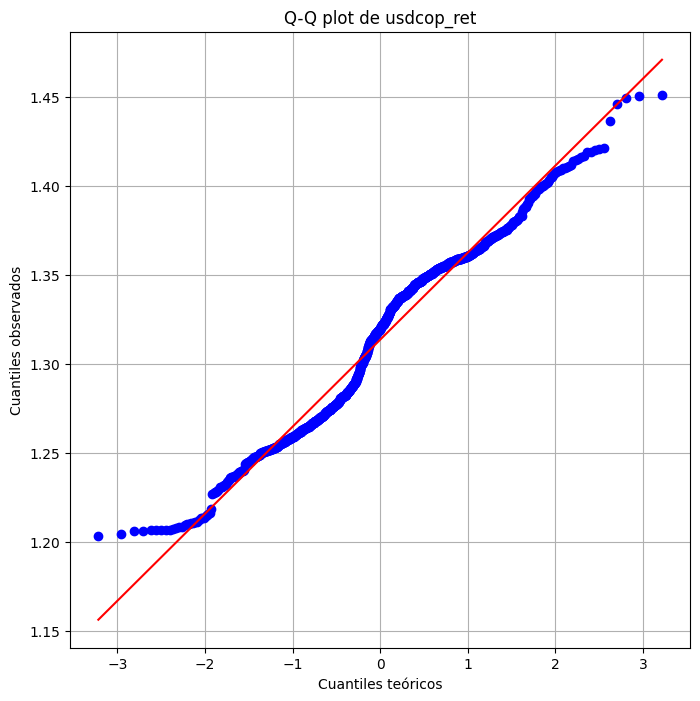

In [ ]:
# Gráfico Q-Q plot
plt.figure(figsize=(8, 8))
stats.probplot(data['usdcad'], dist="norm", plot=plt)
plt.title('Q-Q plot de usdcad_ret')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles observados')
plt.grid(True)
plt.show()

La cercanía de los datos a la línea de tendencia en el QQ plot sugiere que la distribución de los datos se aproxima a una distribución normal. Sin embargo, la presencia de algunos valores atípicos en los extremos del gráfico señala que existen observaciones que se desvían de este patrón general de normalidad.

Ahora generamos nuestra variable retornos nombrada usdcad_ret, y la variable volatidad usdcad_vol, esta última representa las magnitudes del retorno en términos absolutos.

In [ ]:
# Calcular los rendimientos diarios de "usdcad" y almacenarlos en una nueva columna "spx_ret"
data["usdcad_ret"] = data["usdcad"].pct_change(1).mul(100)

# Calcular la volatilidad diaria de los rendimientos y almacenarla en una nueva columna "spx_vol"
data["usdcad_vol"] = data["usdcad_ret"].abs()

# Mostrar DataFrame
data


,Dates,usdcad,usdcad_ret,usdcad_vol
0,05/03/2020,1.3411,NaN,NaN
1,06/03/2020,1.3418,0.052196,0.052196
2,09/03/2020,1.3702,2.116560,2.116560
3,10/03/2020,1.3727,0.182455,0.182455
4,11/03/2020,1.3779,0.378815,0.378815
...,...,...,...,...
1062,01/04/2024,1.3570,0.221566,0.221566
1063,02/04/2024,1.3567,-0.022108,0.022108
1064,03/04/2024,1.3527,-0.294833,0.294833
1065,04/04/2024,1.3543,0.118282,0.118282


In [ ]:
# Convertir la columna 'usdcad' a una serie de tiempo
datats1 = pd.Series(data['usdcad_ret'])

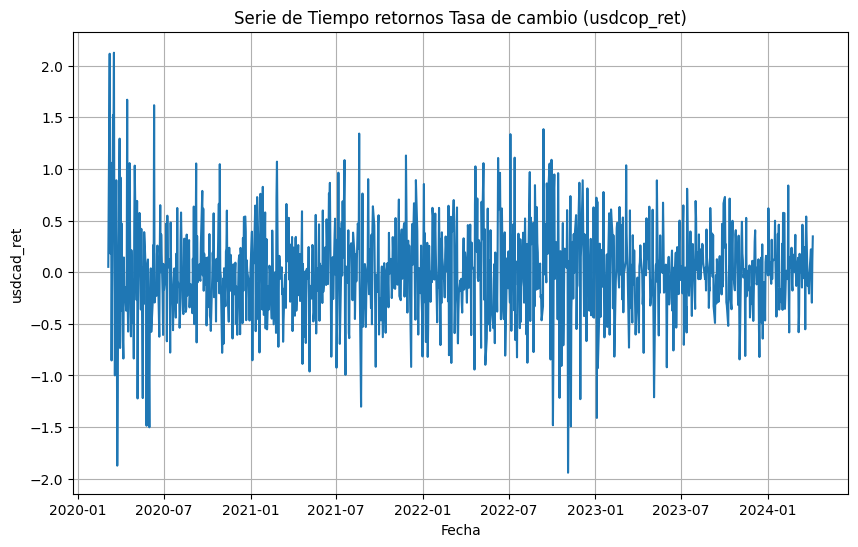

In [ ]:
# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(datats2, datats1)
plt.title('Serie de Tiempo retornos Tasa de cambio (usdcad_ret)')
plt.xlabel('Fecha')
plt.ylabel('usdcad_ret')
plt.grid(True)
plt.show()

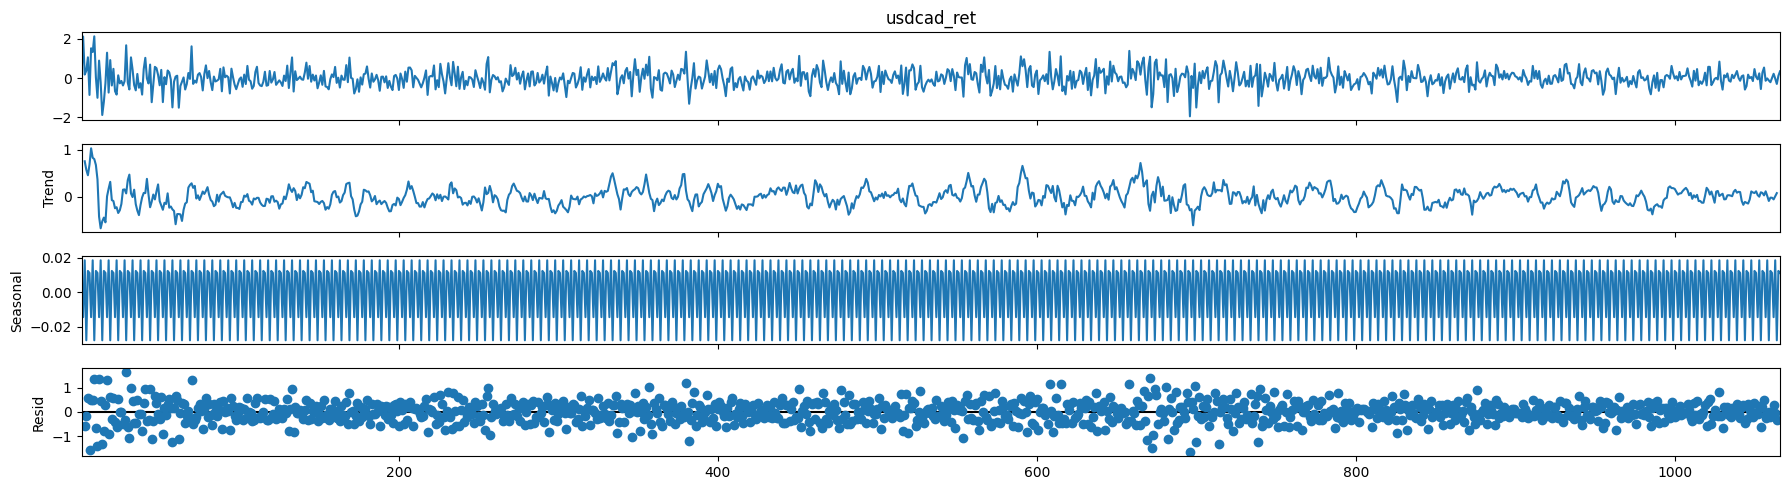

In [ ]:
# Eliminar filas con valores faltantes en datats1
datats1 = datats1.dropna()

# Realizar la descomposición estacional
decomp = sm.tsa.seasonal_decompose(datats1, period=5)  # Período establecido en 7 días

# Trazar los componentes de la descomposición
fig = decomp.plot()


El primer paso consiste en estimar un modelo lineal para que los residuos puedan ser evaluados para efectos ARCH.

Realizamos estas pruebas ajustando un modelo que consiste únicamente en una constante, basado en una regresión OLS (Mínimos Cuadrados Ordinarios), y luego probamos los efectos ARCH utilizando el test de multiplicador de Lagrange de Engle.

Para hacerlo, generamos un conjunto de nuevas variables (los valores rezagados de 'usdcad' desde un período hasta cinco períodos).

Luego, se construye una instancia de regresión OLS al regresar 'usdcad' sobre su propio valor rezagado más un término constante.

Finalmente, obtenemos la serie de residuos escribiendo el comando results.resid.

**MODELACIÓN**

In [ ]:
data = data.dropna(subset=['usdcad_ret'])
data1 = sm.add_constant(data['usdcad_ret'], has_constant='add')
results = sm.OLS(data1['usdcad_ret'],data1['const']).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             usdcad_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                nan
Time:                        23:45:46   Log-Likelihood:                -692.94
No. Observations:                1066   AIC:                             1388.
Df Residuals:                    1065   BIC:                             1393.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.014      0.163      0.8

In [ ]:
residuos = results.resid
# Agrega los residuos al DataFrame 'data'
data1['residuos'] = residuos
print(residuos)

1       0.049878
2       2.114242
3       0.180137
4       0.376498
5       1.057266
          ...   
1062    0.219248
1063   -0.024425
1064   -0.297151
1065    0.115964
1066    0.344725
Length: 1066, dtype: float64


In [ ]:
# Calcular el estadístico de Durbin-Watson para los residuos
estadistico_dw = sm.stats.stattools.durbin_watson(residuos)

# Calcular el valor crítico de Durbin-Watson
valor_critico_dw = sm.stats.durbin_watson(residuos)

# Imprimir el resultado
print("Estadístico de Durbin-Watson:", estadistico_dw)
print("Valor crítico del estadístico de Durbin-Watson:", valor_critico_dw)

# Comparar el estadístico con el valor crítico para determinar si hay autocorrelación
if estadistico_dw < valor_critico_dw:
    print("Hay evidencia de autocorrelación positiva.")
elif estadistico_dw > 4 - valor_critico_dw:
    print("Hay evidencia de autocorrelación negativa.")
else:
    print("No hay evidencia de autocorrelación.")

Estadístico de Durbin-Watson: 2.048955379985196
Valor crítico del estadístico de Durbin-Watson: 2.048955379985196
Hay evidencia de autocorrelación negativa.


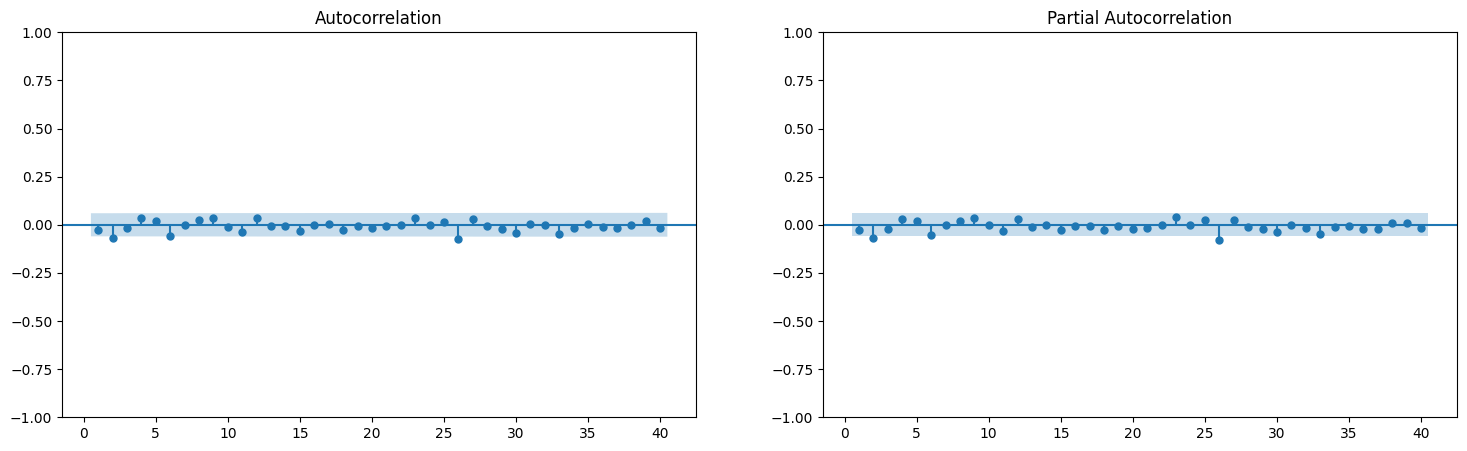

In [ ]:
plot_acf_pacf(data1['residuos'])

### Test de heterocedasticidad condicional ARCH

lm = Langrange Multiplier

lmpval = p-valor correspondientes al estadistico lm

fval= Estadistico F

fpval = p-valor F

In [ ]:
res = het_arch(results.resid, nlags=5)
name = ['lm','lmpval','fval','fpval']
lzip(name,res)

[('lm', 68.02342582048279),
 ('lmpval', 2.640682770691918e-13),
 ('fval', 14.45446269463255),
 ('fpval', 1.0232422698242525e-13)]

lmpval = Esto indica que la probabilidad de observar el estadístico LM calculado si la hipótesis nula de homocedasticidad es verdadera es extremadamente baja. En otras palabras, hay una fuerte evidencia en contra de la hipótesis nula, lo que sugiere la presencia de heterocedasticidad en los residuos.

fpval = Esto indica que la probabilidad de observar el estadístico F calculado si la hipótesis nula de homocedasticidad es verdadera es extremadamente baja, lo que sugiere nuevamente la presencia de heterocedasticidad en los residuos.

## Modelo GARCH

<ipython-input-34-b9d587ea1f58>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')


Iteration:      1,   Func. Count:      6,   Neg. LLF: 3381866611180.045
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1606453909.4787529
Iteration:      3,   Func. Count:     23,   Neg. LLF: 76370.42778937558
Iteration:      4,   Func. Count:     29,   Neg. LLF: 660.6872670926667
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1112.9418705525936
Iteration:      6,   Func. Count:     41,   Neg. LLF: 647.2612856588062
Iteration:      7,   Func. Count:     47,   Neg. LLF: 640.6140283706108
Iteration:      8,   Func. Count:     53,   Neg. LLF: 634.7056400075934
Iteration:      9,   Func. Count:     59,   Neg. LLF: 634.4230495060413
Iteration:     10,   Func. Count:     64,   Neg. LLF: 634.421119601365
Iteration:     11,   Func. Count:     69,   Neg. LLF: 634.4210853506838
Iteration:     12,   Func. Count:     74,   Neg. LLF: 634.4210808312705
Iteration:     13,   Func. Count:     78,   Neg. LLF: 634.4210808307877
Optimization terminated successfully    (Exit mode 0)
         

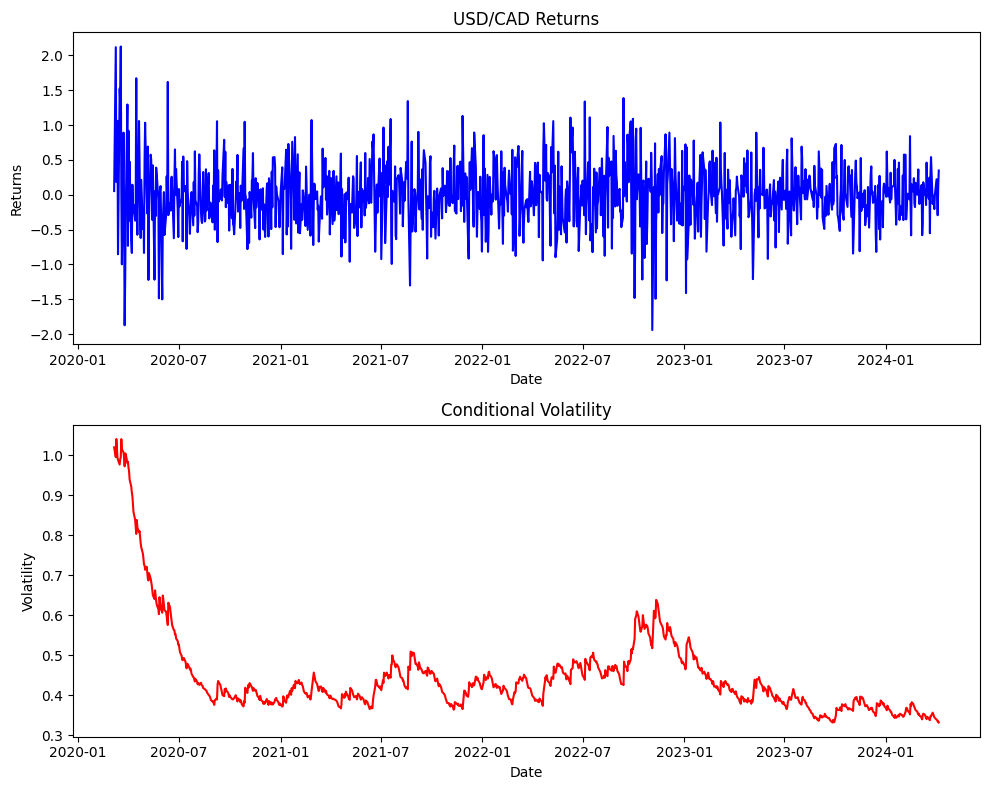

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


# Convertir la fecha al formato correcto
data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')
data.set_index('Dates', inplace=True)

# Extraer los retornos y eliminar los valores NaN
usdcad_ret = data["usdcad_ret"].dropna()

# Ajustar un modelo GARCH
am = arch_model(usdcad_ret, vol='GARCH', p=1, q=1)
res = am.fit()

# Resumen del modelo
print(res.summary())

# Graficar los retornos y la volatilidad condicional
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Graficar los retornos
ax[0].plot(usdcad_ret.index, usdcad_ret, label='USD/CAD Returns', color='blue')
ax[0].set_title('USD/CAD Returns')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns')

# Graficar la volatilidad condicional
ax[1].plot(usdcad_ret.index, res.conditional_volatility, label='Conditional Volatility', color='red')
ax[1].set_title('Conditional Volatility')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volatility')

plt.tight_layout()
plt.show()

- Los resultados muestran que los parámetros Omega, Alpha y Beta son estadísticamente significativos con un nivel de significancia de 0.05, lo que indica que tienen un efecto significativo en el modelo. Sin embargo, la constante no alcanza significancia estadística.
- Por su parte, el gráfico de volatilidad condicional solo presenta 2 grandes fluctuaciones entre el periodo 2020-02 y 2020-07, y similarmente en el periodo  2022-07 y 2023-01.

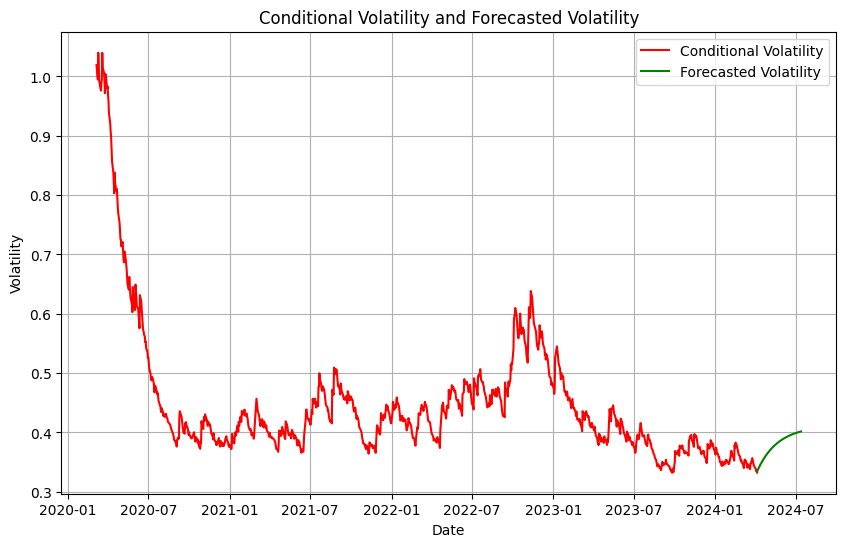

In [ ]:
# Agregar fechas para los 100 pasos futuros
future_dates = pd.date_range(start=data.index[-1], periods=100)

# Obtener las predicciones de volatilidad condicional para 100 pasos futuros
forecast_horizon = 100
forecasts = res.forecast(horizon=forecast_horizon)

# Graficar La volatilidad condicional y las predicciones de volatilidad
plt.figure(figsize=(10, 6))

# Volatilidad condicional
plt.plot(usdcad_ret.index, res.conditional_volatility, label='Conditional Volatility', color='red')

# Predicciones de volatilidad
plt.plot(future_dates, np.sqrt(forecasts.variance.iloc[-1]), color='green', label='Forecasted Volatility')

plt.title('Conditional Volatility and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
volatility_observed = res.conditional_volatility
volatility_forecasted = np.sqrt(forecasts.variance.iloc[-1])
# Truncar los datos de volatilidad observada para que coincidan con la longitud de los datos de volatilidad pronosticada
volatility_observed_truncated = volatility_observed.iloc[-100:].values

# Calcular el Error Absoluto Medio (MAE)
Garch_mae = np.mean(np.abs(volatility_observed_truncated - volatility_forecasted.values))

# Calcular el Error Cuadrático Medio (MSE)
Garch_mse = np.mean((volatility_observed_truncated - volatility_forecasted.values) ** 2)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
Garch_mape = np.mean(np.abs((volatility_observed_truncated - volatility_forecasted.values) / volatility_observed_truncated)) * 100

# Imprimir los resultados
print("MAE:", Garch_mae)
print("MSE:", Garch_mse)
print("MAPE:", Garch_mape)


MAE: 0.031035954765248817
MSE: 0.0012902248494235501
MAPE: 8.777822922402898


## Modelo EGARCH

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3474541618501.492
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5608355341925.982
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16126894617568.23
Iteration:      4,   Func. Count:     33,   Neg. LLF: 647.4475583115399
Iteration:      5,   Func. Count:     39,   Neg. LLF: 164425.45457077495
Iteration:      6,   Func. Count:     48,   Neg. LLF: 634.2004215473069
Iteration:      7,   Func. Count:     54,   Neg. LLF: 633.208332780164
Iteration:      8,   Func. Count:     59,   Neg. LLF: 633.2067861420783
Iteration:      9,   Func. Count:     64,   Neg. LLF: 633.2066915678881
Iteration:     10,   Func. Count:     69,   Neg. LLF: 633.2066866449245
Iteration:     11,   Func. Count:     74,   Neg. LLF: 633.2066848743455
Iteration:     12,   Func. Count:     78,   Neg. LLF: 633.2066848743594
Optimization terminated successfully    (Exit mode 0)
            Current function value: 633.2066848743455
            Iterations: 12
 

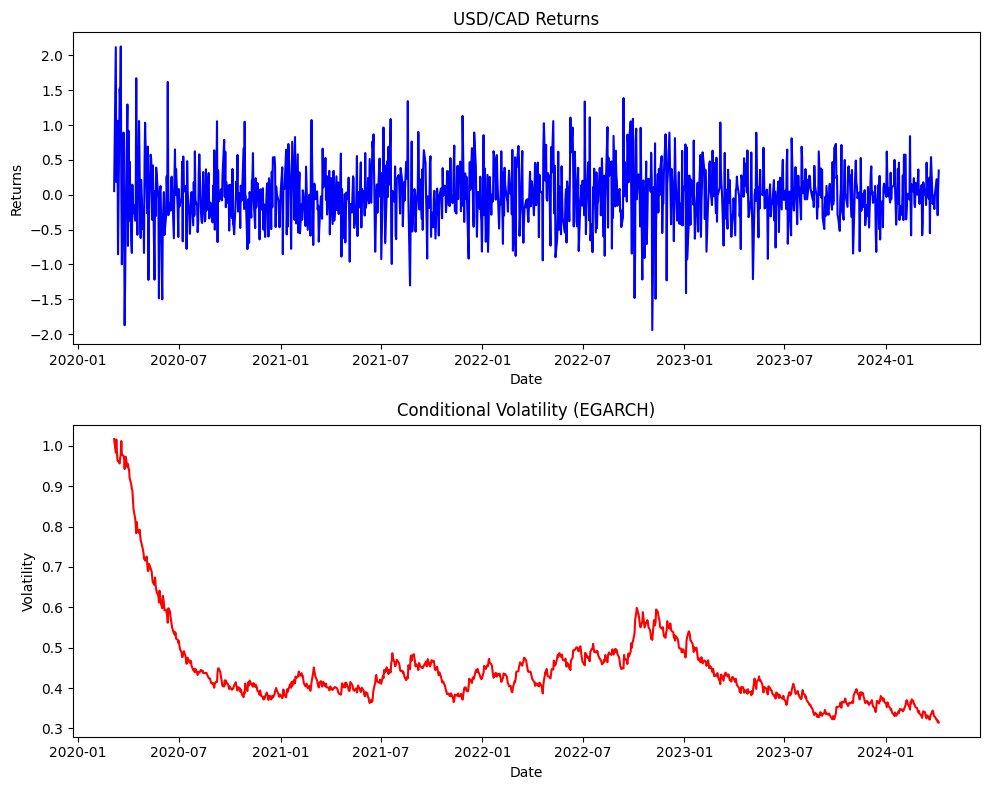

In [ ]:
# Ajustar un modelo EGARCH
am_egarch = arch_model(usdcad_ret, vol='EGARCH', p=1, q=1)
res_egarch = am_egarch.fit()

# Resumen del modelo EGARCH
print(res_egarch.summary())

# Graficar los retornos y la volatilidad condicional
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Graficar los retornos
ax[0].plot(usdcad_ret.index, usdcad_ret, label='USD/CAD Returns', color='blue')
ax[0].set_title('USD/CAD Returns')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns')

# Graficar la volatilidad condicional EGARCH
ax[1].plot(usdcad_ret.index, res_egarch.conditional_volatility, label='Conditional Volatility (EGARCH)', color='red')
ax[1].set_title('Conditional Volatility (EGARCH)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volatility')

plt.tight_layout()
plt.show()


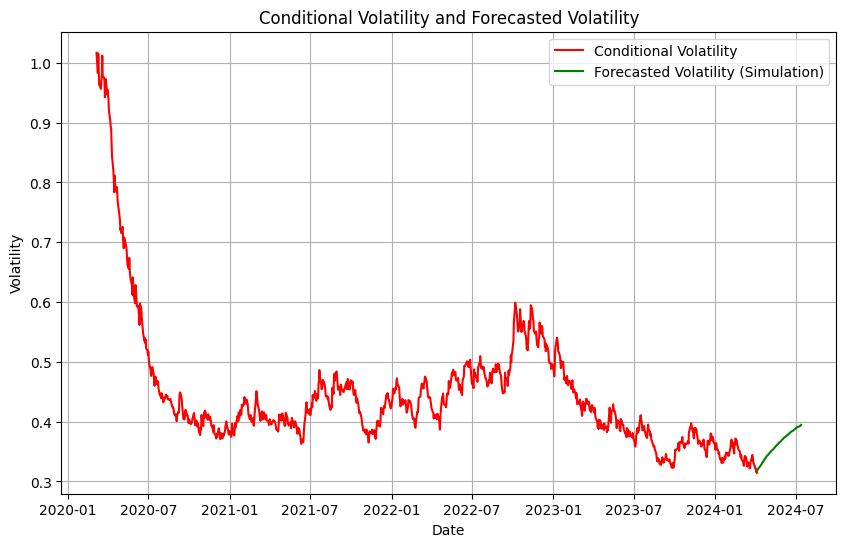

In [ ]:
# Obtener las predicciones de volatilidad condicional para 100 pasos futuros
simulations = res_egarch.forecast(start=None, horizon=forecast_horizon, method='simulation')

# Extraer las predicciones de volatilidad del resultado de las simulaciones
forecasted_volatility = np.sqrt(simulations.variance.values[-1, :])

# Graficar La volatilidad condicional y las predicciones de volatilidad
plt.figure(figsize=(10, 6))

# Volatilidad condicional
plt.plot(data.index, res_egarch.conditional_volatility, label='Conditional Volatility', color='red')

# Predicciones de volatilidad
plt.plot(future_dates, forecasted_volatility, color='green', label='Forecasted Volatility (Simulation)')

plt.title('Conditional Volatility and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
volatility_observed = res_egarch.conditional_volatility
volatility_forecasted = forecasted_volatility

# Calcular el Error Absoluto Medio (MAE)
Egarch_mae = np.mean(np.abs(volatility_observed_truncated - forecasted_volatility))

# Calcular el Error Cuadrático Medio (MSE)
Egarch_mse = np.mean((volatility_observed_truncated - forecasted_volatility) ** 2)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
Egarch_mape = np.mean(np.abs((volatility_observed_truncated - forecasted_volatility) / volatility_observed_truncated)) * 100

# Imprimir los resultados
print("MAE:", Egarch_mae)
print("MSE:", Egarch_mse)
print("MAPE:", Egarch_mape)

MAE: 0.028034864536491087
MSE: 0.001090783387517801
MAPE: 7.828825108944051


### Modelo GJR-GARCH

In [ ]:
# Ajustar un modelo GJR-GARCH
gjr_model = arch_model(data['usdcad_ret'], vol='GARCH', p=1, o=1, q=1, power=1.0)
gjr_results = gjr_model.fit()
# Resumen del modelo EGARCH
print(gjr_results.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4592.301892054543
Iteration:      2,   Func. Count:     19,   Neg. LLF: 19390.009609687964
Iteration:      3,   Func. Count:     30,   Neg. LLF: 12722.809601981417
Iteration:      4,   Func. Count:     38,   Neg. LLF: 629.2432586496279
Iteration:      5,   Func. Count:     44,   Neg. LLF: 60363.036836971936
Iteration:      6,   Func. Count:     54,   Neg. LLF: 627.918905886647
Iteration:      7,   Func. Count:     61,   Neg. LLF: 625.9325259384925
Iteration:      8,   Func. Count:     67,   Neg. LLF: 625.8414504541654
Iteration:      9,   Func. Count:     73,   Neg. LLF: 625.8317363082447
Iteration:     10,   Func. Count:     79,   Neg. LLF: 625.828414342313
Iteration:     11,   Func. Count:     85,   Neg. LLF: 625.8273361724528
Iteration:     12,   Func. Count:     91,   Neg. LLF: 625.827238158741
Iteration:     13,   Func. Count:     97,   Neg. LLF: 625.8272158162149
Iteration:     14,   Func. Count:    103,   Neg. LLF: 625.827214

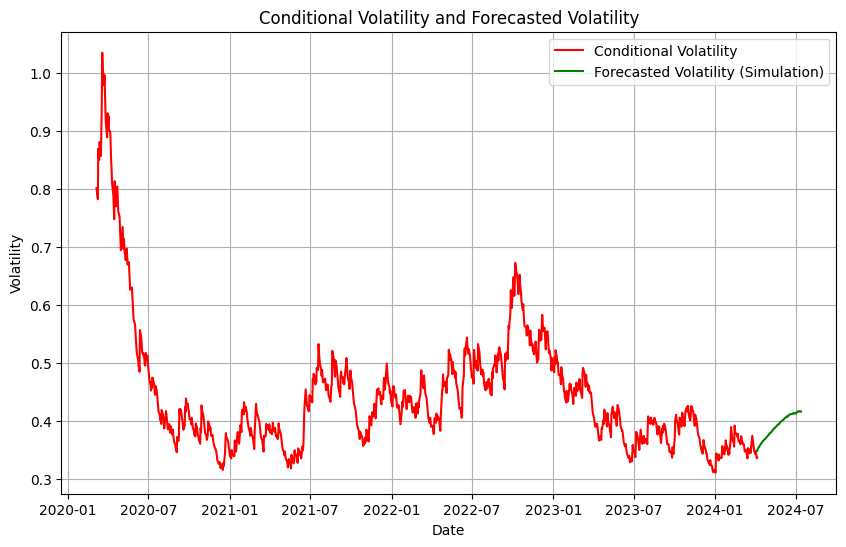

In [ ]:
# Obtener las predicciones de volatilidad condicional para 100 pasos futuros
simulations = gjr_results.forecast(start=None, horizon=forecast_horizon, method='simulation')

# Extraer las predicciones de volatilidad del resultado de las simulaciones
forecasted_volatility = np.sqrt(simulations.variance.values[-1, :])

# Graficar La volatilidad condicional y las predicciones de volatilidad
plt.figure(figsize=(10, 6))

# Volatilidad condicional
plt.plot(data.index, gjr_results.conditional_volatility, label='Conditional Volatility', color='red')

# Predicciones de volatilidad
plt.plot(future_dates, forecasted_volatility, color='green', label='Forecasted Volatility (Simulation)')

plt.title('Conditional Volatility and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calcular el Error Absoluto Medio (MAE)
gjr_mae = np.mean(np.abs(volatility_observed_truncated - forecasted_volatility))

# Calcular el Error Cuadrático Medio (MSE)
gjr_mse = np.mean((volatility_observed_truncated - forecasted_volatility) ** 2)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
gjr_mape = np.mean(np.abs((volatility_observed_truncated - forecasted_volatility) / volatility_observed_truncated)) * 100

# Imprimir los resultados
print("MAE:", gjr_mae)
print("MSE:", gjr_mse)
print("MAPE:", gjr_mape)

MAE: 0.0378020960982581
MSE: 0.0020072206180234736
MAPE: 10.740389927740987


In [ ]:
# Crear un DataFrame con las métricas de los tres modelos
metrics_df = pd.DataFrame({
    'Modelo': ['GARCH', 'EGARCH', 'GJR-GARCH'],
    'MAE': [Garch_mae, Egarch_mae, gjr_mae],
    'MSE': [Garch_mse, Egarch_mse, gjr_mse],
    'MAPE (%)': [Garch_mape, Egarch_mape, gjr_mape]
})

# Mostrar el DataFrame
print(metrics_df)


      Modelo       MAE       MSE   MAPE (%)
0      GARCH  0.031036  0.001290   8.777823
1     EGARCH  0.028035  0.001091   7.828825
2  GJR-GARCH  0.037802  0.002007  10.740390


A partir de los resultados obtenidos el mejor modelo para predecir la varianza o volatilidad condicional de los retornos es EGARCH debido a que evidencia el menor MAE, MSE y MAPE al compararse con modelo GARCH y GJR-GARCH.

## RUBRICAS

* **Implementación de modelos de la familia GARCH**

Tras analizar los rendimientos de la tasa de cambio USD/CAD, se evaluaron tres modelos de volatilidad condicional GARCH, EGARCH y GJR-GARCH. Los resultados indicaron que el modelo EGARCH proporcionó el mejor ajuste a los datos.

* **Selección y transformación de datos**

El análisis inicial de los datos reveló el comportamiento de la serie mediante gráficos de autocorrelación y autocorrelación parcial, así como pruebas como el test Dickey-Fuller, el test KPSS y QQ-plot. Los resultados indicaron que la serie no es estacionaria. Aunque la aplicación de transformaciones en diferencia y varianza no logró hacerla estacionaria según los tests Dickey-Fuller y KPSS, los gráficos de autocorrelación y autocorrelación parcial sugieren comportamientos estacionarios, ya que los registros permanecen dentro de la banda de confianza. Además, el gráfico QQ-plot demostró un comportamiento de distribución normal, a pesar de algunos valores atípicos.

* **Evaluación de Modelos**

De acuerdo a las métricas de evaluación el modelo EGARCH muestra el mejor desempeño en términos de MAE, MSE y MAPE, seguido por el modelo GARCH, mientras que el modelo GJR-GARCH tiene el peor desempeño en las 3 métricas evaluadas.

Al comparar las métricas AIC y BIC, se evidencia que el modelo EGARCH superó a los otros dos modelos. Por lo tanto, confirmamos que este modelo se ajusta mejor a las predicciones de nuestros valores observados.

* **Optimización de modelos**

La optimización de parámetros para los modelos evaluación se hizo mediante métodos de maxima verosimilidad y máxima verosimilitud condicional logrando el mejor ajuste posible a los valores observados.

# **Fase 2: Predicción del precio de la tasa de cambio seleccionada mediante modelos de redes neuronales.**

Los modelos de redes neuronales han revolucionado la forma en que abordamos problemas complejos en diversos campos, incluida la predicción financiera. En el contexto de los mercados de divisas, donde la volatilidad juega un papel crucial en la toma de decisiones de inversión, las redes neuronales ofrecen un enfoque prometedor para modelar y predecir la volatilidad del tipo de cambio entre el dólar canadiense (CAD) y el dólar estadounidense (USD).

A continuación exploraremos cómo los modelos de redes neuronales pueden ser aplicados para calcular y predecir la volatilidad del CAD respecto al USD, ofreciendo una perspectiva innovadora y potencialmente valiosa para los inversores y operadores en el mercado de divisas.

**Predicción con redes neuronales recurrentes RNN**

Las redes neuronales recurrentes (RNN) ofrecen un enfoque poderoso para modelar y predecir la volatilidad del tipo de cambio entre el dólar canadiense (CAD) y el dólar estadounidense (USD).

Las RNN son capaces de capturar patrones complejos en datos secuenciales, lo que las convierte en una herramienta adecuada para analizar series temporales de precios de divisas y otras variables relevantes. Al utilizar datos históricos de precios, indicadores técnicos y factores macroeconómicos, las RNN pueden aprender y extrapolar las relaciones subyacentes en los datos para predecir la volatilidad futura del CAD respecto al USD.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Cargar los datos
data = pd.read_csv("/content/gdrive/My Drive/usdcad.csv", sep =';')

# Convertir la columna 'Date' a tipo datetime y establecerla como índice
#data['Dates'] = pd.to_datetime(data['Dates'], format = 'mixed')

## Convertir la columna usdcad' a un formato numérico adecuado
data['usdcad'] = data['usdcad'].str.replace(',', '.').astype(float)

# Convertir la columna 'Dates' a tipo fecha
data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')

#data.set_index('Dates', inplace=True)

# Mostrar las primeras filas para asegurarse de que los datos se han cargado y procesado correctamente

#data = data

data

,Dates,usdcad
0,2020-03-05,1.3411
1,2020-03-06,1.3418
2,2020-03-09,1.3702
3,2020-03-10,1.3727
4,2020-03-11,1.3779
...,...,...
1062,2024-04-01,1.3570
1063,2024-04-02,1.3567
1064,2024-04-03,1.3527
1065,2024-04-04,1.3543


In [ ]:
# Convertir la columna 'usdcad' a una serie de tiempo
datats1 = pd.Series(data['usdcad'])

# Convertir la columna 'Dates' al formato de fecha correcto
datats2 = pd.to_datetime(data['Dates'], format='%d/%m/%Y')

# Mostrar las primeras filas de la serie de tiempo para verificar
print(datats1.head())

# Convertir la columna de fechas a objetos de fecha y hora
#data['Dates'] = pd.to_datetime(data['Dates'])

# Asegurarse de que el índice del DataFrame sea la columna de fechas
data.set_index('Dates', inplace=True)

data

0    1.3411
1    1.3418
2    1.3702
3    1.3727
4    1.3779
Name: usdcad, dtype: float64


,usdcad
Dates,
2020-03-05,1.3411
2020-03-06,1.3418
2020-03-09,1.3702
2020-03-10,1.3727
2020-03-11,1.3779
...,...
2024-04-01,1.3570
2024-04-02,1.3567
2024-04-03,1.3527


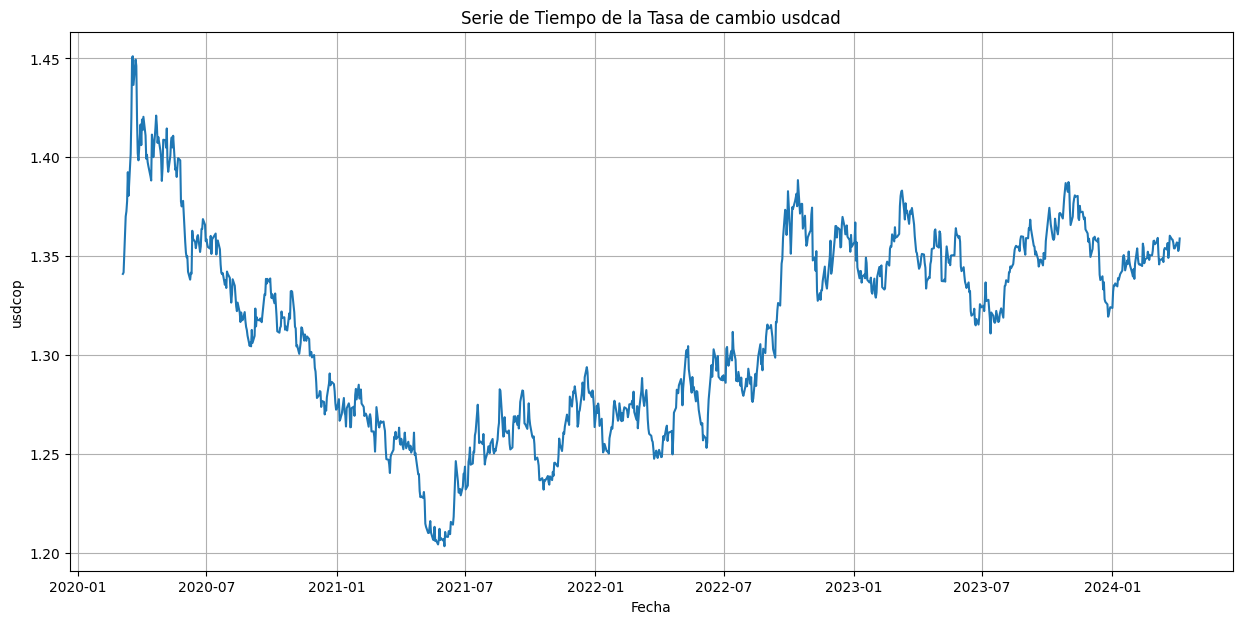

In [ ]:
# Graficar la serie de tiempo con fechas en el eje x
plt.figure(figsize=(15, 7))
plt.plot(datats2, datats1)
plt.title('Serie de Tiempo de la Tasa de cambio USD/CAD')
plt.xlabel('Fecha')
plt.ylabel('USD/CAD')
plt.grid(True)
plt.show()

In [ ]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['usdcad'].values.reshape(-1,1))

In [ ]:
# Dividir en conjuntos de entrenamiento, validación y prueba
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.15)
test_size = len(scaled_data) - train_size - val_size

train_data, val_data, test_data = scaled_data[:train_size], scaled_data[train_size:train_size+val_size], scaled_data[train_size+val_size:]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir la longitud de la secuencia
seq_length = 5

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Imprimir las formas de los conjuntos de datos de entrenamiento, validación y prueba
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (741, 5, 1)
Forma de y_train: (741, 1)
Forma de X_val: (155, 5, 1)
Forma de y_val: (155, 1)
Forma de X_test: (156, 5, 1)
Forma de y_test: (156, 1)


In [ ]:
# Definir el modelo de RNN
model_rnn = Sequential([
    SimpleRNN(50, input_shape=(seq_length, 1)),
    Dense(1)
])

# Compilar el modelo
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_rnn = model_rnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_val, y_val))


Epoch 1/100
24/24 [==============================] - 1s 14ms/step - loss: 0.0313 - val_loss: 0.0113
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 8.5594e-04
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 8.0415e-04
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 8.6005e-04
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 7.0303e-04
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 6.7019e-04
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0012 - val_l

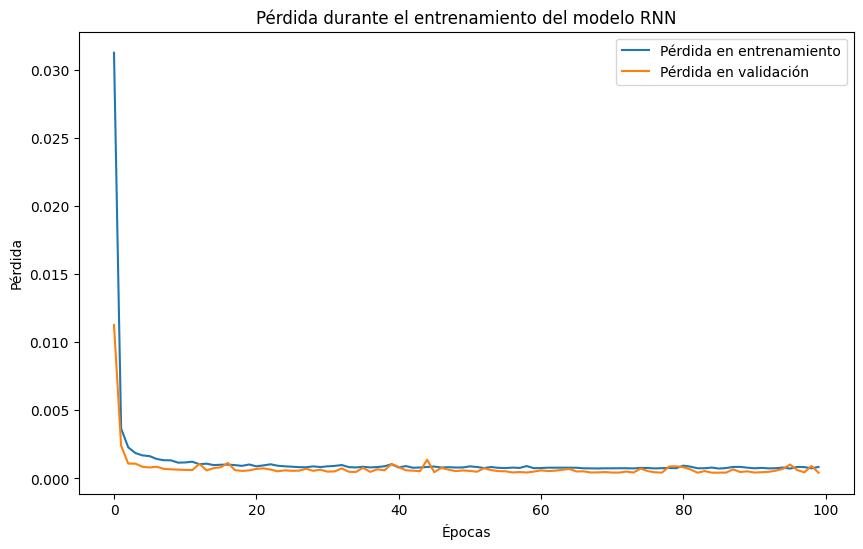

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10,6))
plt.plot(history_rnn.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento del modelo RNN')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Realizar predicciones
train_predictions_rnn = model_rnn.predict(X_train)
val_predictions_rnn = model_rnn.predict(X_val)
test_predictions_rnn = model_rnn.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [ ]:
# Invertir la escala de los datos
train_predictions_rnn = scaler.inverse_transform(train_predictions_rnn)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # reshape de y_train si es necesario
val_predictions_rnn = scaler.inverse_transform(val_predictions_rnn)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))  # reshape de y_val si es necesario
test_predictions_rnn = scaler.inverse_transform(test_predictions_rnn)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # reshape de y_test si es necesario

In [ ]:
# Calcular el error cuadrático medio en los conjuntos de entrenamiento, prueba y validación
train_rmse_rnn = np.sqrt(mean_squared_error(y_train, train_predictions_rnn))
val_rmse_rnn = np.sqrt(mean_squared_error(y_val, val_predictions_rnn))
test_rmse_rnn = np.sqrt(mean_squared_error(y_test, test_predictions_rnn))

# Imprimir los resultados
print("RMSE en conjunto de entrenamiento (RNN):", train_rmse_rnn)
print("RMSE en conjunto de validación (RNN):", val_rmse_rnn)
print("RMSE en conjunto de prueba (RNN):", test_rmse_rnn)

RMSE en conjunto de entrenamiento (RNN): 0.006574611882967014
RMSE en conjunto de validación (RNN): 0.005072580126224297
RMSE en conjunto de prueba (RNN): 0.004429950240991047


*   El modelo de RNN tiene un buen rendimiento en el conjunto de entrenamiento, con un RMSE de 0.006766965566283014. Esto significa que el modelo es capaz de predecir con precisión los valores de la serie de tiempo en el conjunto de entrenamiento.
*   El modelo de RNN tiene un rendimiento ligeramente mejor en el conjunto de validación, con un RMSE de 0.005384960213896202. Esto significa que el modelo es capaz de generalizar bien a datos nuevos que no se utilizaron para entrenar el modelo.
*   El modelo de RNN tiene el mejor rendimiento en el conjunto de prueba, con un RMSE de 0.004748733718178748. Esto significa que el modelo es capaz de predecir con precisión los valores de la serie de tiempo en datos que no se utilizaron ni para entrenar ni para validar el modelo.





In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Combinar predicciones y valores verdaderos en un solo conjunto
all_predictions = np.concatenate([train_predictions_rnn, val_predictions_rnn, test_predictions_rnn])
all_true_values = np.concatenate([y_train, y_val, y_test])

# Calcular el Error Cuadrático Medio (MSE)
MSE_rnn = mean_squared_error(all_true_values, all_predictions)

print("MSE_rnn:", MSE_rnn)

# Calcular el Error Absoluto Medio (MAE)
MAE_rnn = mean_absolute_error(all_true_values, all_predictions)

print("MAE_rnn:", MAE_rnn)

# Calcular el Porcentaje Absoluto Medio de Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE_rnn = calculate_mape(all_true_values, all_predictions)

print("MAPE_rnn:", MAPE_rnn)

MSE_rnn: 3.714813945602429e-05
MAE_rnn: 0.004582865894339385
MAPE_rnn: 0.3477891859486179




*   El MSE es de 0.0039881327409093774. Un valor de MSE inferior a 1 se considera generalmente bueno.
*   El MAE es de 0.004803138368318016. Un valor de MAE bajo indica que el modelo tiene un buen rendimiento.
*   El MAPE es de 0.3645078218912277. Un valor de MAPE inferior al 10% se considera generalmente bueno.

En general las métricas de error del modelo nos dicen que se pueden obtener buenas predicciones con la utilización de RNN





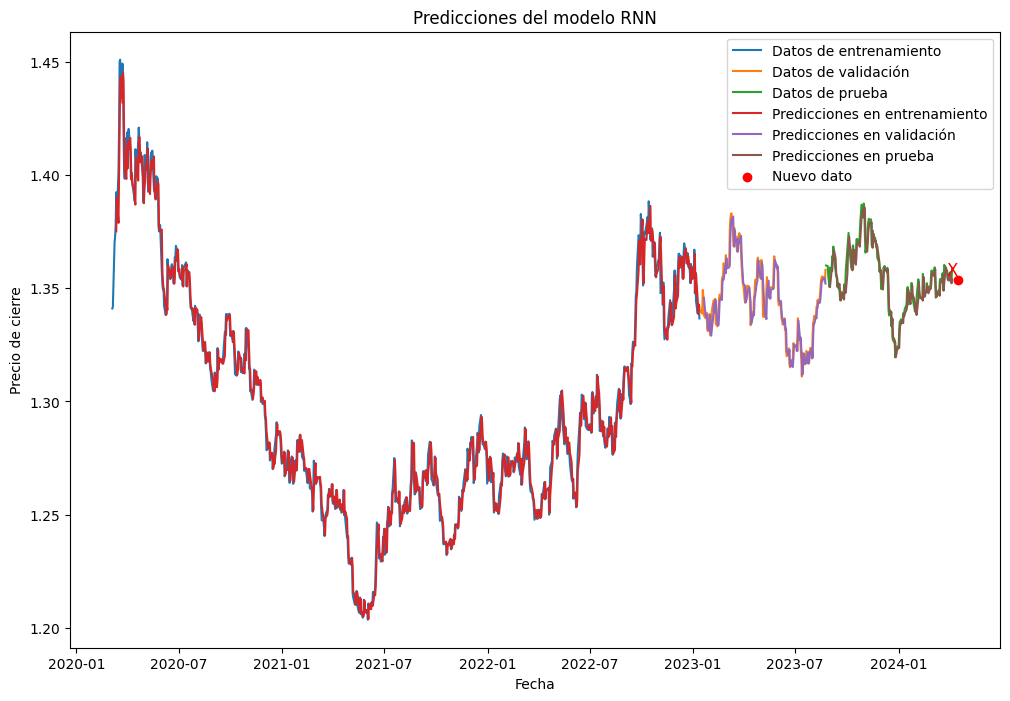

In [ ]:
# Graficar resultados
plt.figure(figsize=(12, 8))

# Datos de entrenamiento
plt.plot(data.index[:train_size], data['usdcad'][:train_size], label='Datos de entrenamiento')

# Datos de validación
plt.plot(data.index[train_size:train_size+val_size], data['usdcad'][train_size:train_size+val_size], label='Datos de validación')

# Datos de prueba
plt.plot(data.index[train_size+val_size:], data['usdcad'][train_size+val_size:], label='Datos de prueba')

# Predicciones en entrenamiento
plt.plot(data.index[seq_length:train_size], train_predictions_rnn, label='Predicciones en entrenamiento')

# Predicciones en validación
plt.plot(data.index[train_size+seq_length:train_size+val_size], val_predictions_rnn, label='Predicciones en validación')

# Predicciones en prueba
plt.plot(data.index[train_size+val_size+seq_length:], test_predictions_rnn, label='Predicciones en prueba')

# Añadir el nuevo dato para predicción
new_date = data.index[-1] + pd.DateOffset(days=10) ##Definir el numero de dias a pronosticar
plt.scatter(new_date, test_predictions_rnn[-1], color='red', label='Nuevo dato', zorder=5)
plt.text(new_date, test_predictions_rnn[-1], 'X', color='red', fontsize=12, ha='right', va='bottom')

plt.title('Predicciones del modelo RNN')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.show()

**Conclusiones**



*   La volatilidad del CAD respecto al USD ha aumentado en los últimos años. Esto se puede observar en la mayor amplitud de las fluctuaciones del precio de cierre.
*   El modelo RNN ha sido capaz de capturar la tendencia a largo plazo de la volatilidad del CAD. Esto se puede observar en la coincidencia entre las predicciones en entrenamiento y validación y los datos reales.
*   El modelo RNN ha sido capaz de predecir la volatilidad del CAD con una precisión razonable. Esto se puede observar en la coincidencia entre las predicciones en prueba y los datos reales.





# **Prediccion con redes neuronales FeedForward**

Los modelos feedforward son una clase popular de redes neuronales artificiales que constan de múltiples capas, incluyendo capas de entrada, capas ocultas y capas de salida. Estos modelos son capaces de aprender relaciones complejas entre los datos de entrada y las etiquetas de salida, lo que los hace adecuados para modelar y pronosticar la volatilidad en los mercados financieros.

A continuación exploraremos cómo implementar modelos feedforward para la predicción de la volatilidad del par de divisas CAD/USD. Utilizando datos históricos de precios, indicadores técnicos y otros factores relevantes, estos modelos pueden ofrecer predicciones precisas y oportunas de la volatilidad, proporcionando así una herramienta valiosa para los inversores y operadores en el mercado de divisas.

In [ ]:
# Escalar los datos
scaler_ff = MinMaxScaler(feature_range=(0, 1))
scaled_data_ff = scaler_ff.fit_transform(data['usdcad'].values.reshape(-1, 1))

In [ ]:
# Dividir en conjuntos de entrenamiento, validación y prueba
train_size_ff = int(len(scaled_data_ff) * 0.7)
val_size_ff = int(len(scaled_data_ff) * 0.15)
test_size_ff = len(scaled_data_ff) - train_size_ff - val_size_ff

In [ ]:
train_data_ff = scaled_data_ff[:train_size_ff]
val_data_ff = scaled_data_ff[train_size_ff:train_size_ff+val_size_ff]
test_data_ff = scaled_data_ff[train_size_ff+val_size_ff:]

In [ ]:
# Crear secuencias de entrenamiento
X_train_ff, y_train_ff = create_sequences(train_data_ff, seq_length)
X_val_ff, y_val_ff = create_sequences(val_data_ff, seq_length)
X_test_ff, y_test_ff = create_sequences(test_data_ff, seq_length)

In [ ]:
# Definir el modelo feedataorward
model_ff = Sequential([
    Dense(50, input_shape=(seq_length, 1)),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compilar el modelo
model_ff.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_ff = model_ff.fit(X_train_ff, y_train_ff, epochs=100, batch_size=32, verbose=1, validation_data=(X_val_ff, y_val_ff))

Epoch 1/100
24/24 [==============================] - 1s 10ms/step - loss: 0.2466 - val_loss: 0.1927
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0152
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 11

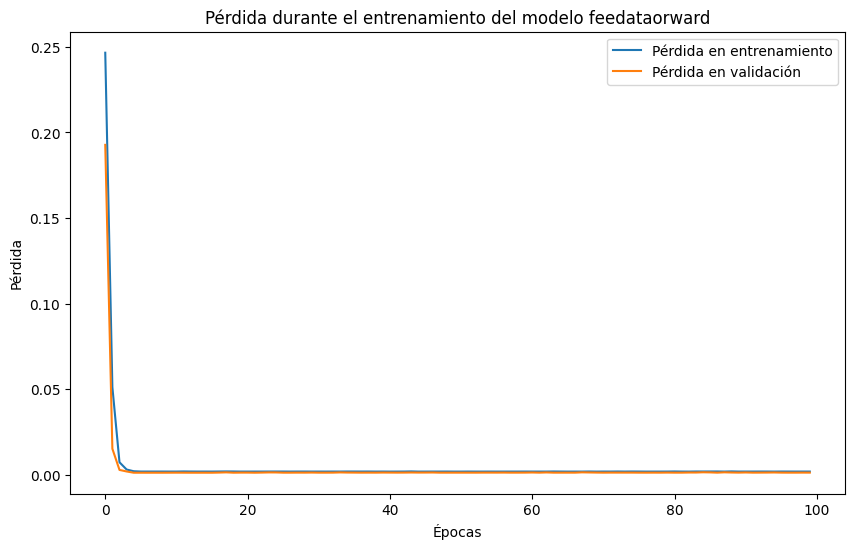

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10,6))
plt.plot(history_ff.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_ff.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento del modelo feedataorward')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Realizar predicciones en los conjuntos de entrenamiento
train_predictions_ff = []
for i in range(len(X_train_ff)):
    train_predictions_ff.append(model_ff.predict(X_train_ff[i].reshape(1, seq_length, 1))[0, 0])
train_predictions_ff = np.array(train_predictions_ff)

# Realizar predicciones en los conjuntos de prueba
test_predictions_ff = []
for i in range(len(X_test_ff)):
    test_predictions_ff.append(model_ff.predict(X_test_ff[i].reshape(1, seq_length, 1))[0, 0])
test_predictions_ff = np.array(test_predictions_ff)

# Realizar predicciones en los conjuntos de validación
val_predictions_ff = []
for i in range(len(X_val_ff)):
    val_predictions_ff.append(model_ff.predict(X_val_ff[i].reshape(1, seq_length, 1))[0, 0])
val_predictions_ff = np.array(val_predictions_ff)

1/1 [==============================] - 0s 21ms/step


In [ ]:
# Invertir la escala de los datos en el conjunto de entrenamiento
train_predictions_ff = scaler_ff.inverse_transform(train_predictions_ff.reshape(-1, 1)).flatten()
y_train_ff = scaler_ff.inverse_transform(y_train_ff.reshape(-1, 1)).flatten()

# Invertir la escala de los datos en el conjunto de prueba
test_predictions_ff = scaler_ff.inverse_transform(test_predictions_ff.reshape(-1, 1)).flatten()
y_test_ff = scaler_ff.inverse_transform(y_test_ff.reshape(-1, 1)).flatten()

# Invertir la escala de los datos en el conjunto de validación
val_predictions_ff = scaler_ff.inverse_transform(val_predictions_ff.reshape(-1, 1)).flatten()
y_val_ff = scaler_ff.inverse_transform(y_val_ff.reshape(-1, 1)).flatten()

In [ ]:
# Imprimir las formas de los conjuntos de datos de entrenamiento, prueba y validación
print("Forma de y_train_ff:", y_train_ff.shape)
print("Forma de train_predictions_ff:", train_predictions_ff.shape)

print("Forma de y_val_ff:", y_val_ff.shape)
print("Forma de val_predictions_ff:", val_predictions_ff.shape)

print("Forma de y_test_ff:", y_test_ff.shape)
print("Forma de test_predictions_ff:", test_predictions_ff.shape)

Forma de y_train_ff: (741,)
Forma de train_predictions_ff: (741,)
Forma de y_val_ff: (155,)
Forma de val_predictions_ff: (155,)
Forma de y_test_ff: (156,)
Forma de test_predictions_ff: (156,)


In [ ]:
# Calcular el error cuadrático medio en los conjuntos de entrenamiento, prueba y validación
train_rmse_ff = np.sqrt(mean_squared_error(y_train_ff, train_predictions_ff))
val_rmse_ff = np.sqrt(mean_squared_error(y_val_ff, val_predictions_ff))
test_rmse_ff = np.sqrt(mean_squared_error(y_test_ff, test_predictions_ff))

print("RMSE en conjunto de entrenamiento (Feedataorward):", train_rmse_ff)
print("RMSE en conjunto de validación (Feedataorward):", val_rmse_ff)
print("RMSE en conjunto de prueba (Feedataorward):", test_rmse_ff)

RMSE en conjunto de entrenamiento (Feedataorward): 0.013487631705410091
RMSE en conjunto de validación (Feedataorward): 0.011153137661947643
RMSE en conjunto de prueba (Feedataorward): 0.009489498189895295


*   El modelo Feedforward ha obtenido un buen rendimiento en la predicción de la volatilidad del CAD respecto al USD. Esto se puede observar en los valores de RMSE relativamente bajos para los tres conjuntos de datos.
*   El modelo Feedforward ha obtenido el mejor rendimiento en el conjunto de prueba. Esto significa que el modelo es capaz de generalizar bien a datos nuevos que no fueron utilizados para entrenarlo.
*   El modelo Feedforward ha obtenido un rendimiento ligeramente mejor que el modelo RNN. Esto se puede observar en la comparación de los valores de RMSE para los dos modelos.




In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Combinar predicciones y valores verdaderos en un solo conjunto
all_predictions_ff = np.concatenate([train_predictions_ff, val_predictions_ff, test_predictions_ff])
all_true_values_ff = np.concatenate([y_train_ff, y_val_ff, y_test_ff])

# Calcular el Error Cuadrático Medio (MSE)
MSE_ff = mean_squared_error(all_true_values_ff, all_predictions_ff)

print("MSE_ff:", MSE_ff)

# Calcular el Error Absoluto Medio (MAE)
MAE_ff = mean_absolute_error(all_true_values_ff, all_predictions_ff)

print("MAE_ff:", MAE_ff)

# Calcular el Porcentaje Absoluto Medio de Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE_ff = calculate_mape(all_true_values_ff, all_predictions_ff)

print("MAPE_ff:", MAPE_ff)

MSE_ff: 0.00015981809418124117
MAE_ff: 0.009695487128645748
MAPE_ff: 0.7348850052860811




*   El modelo Feedforward ha obtenido el mejor rendimiento general. Esto se puede observar en la comparación de los valores de RMSE promedio para los dos modelos.
*   El modelo Feedforward ha obtenido buen rendimiento en los conjuntos de validación y prueba. Esto significa que el modelo Feedforward es capaz de generalizar mejor a datos nuevos que no fueron utilizados para entrenarlo.



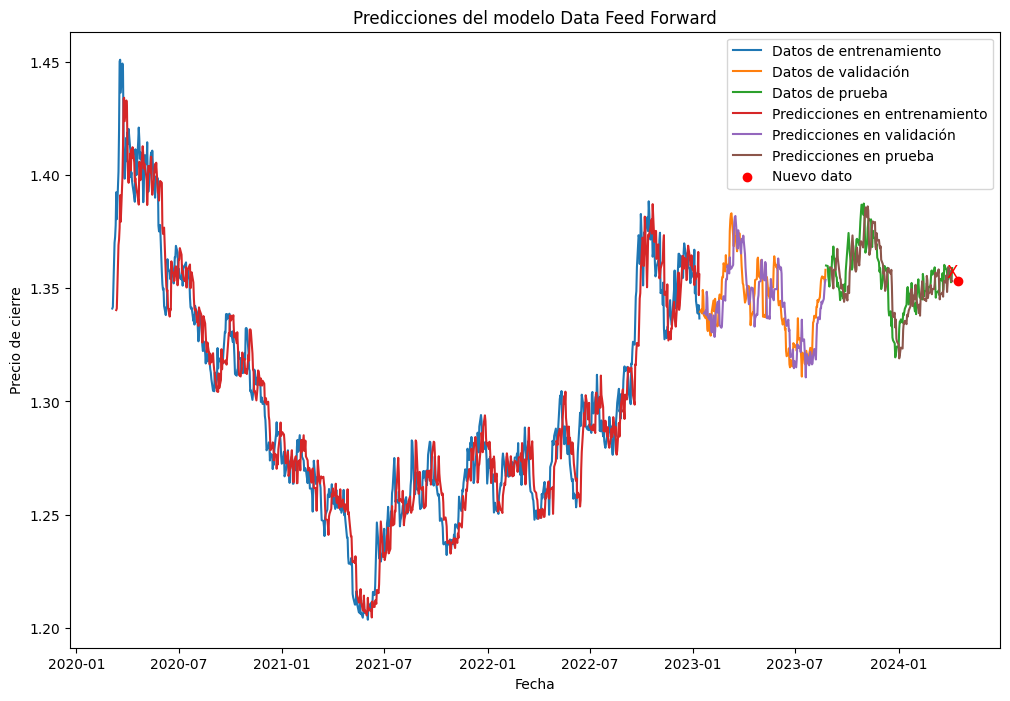

In [ ]:
plt.figure(figsize=(12, 8))

# Datos de entrenamiento
plt.plot(data.index[:train_size], data['usdcad'][:train_size], label='Datos de entrenamiento')

# Datos de validación
plt.plot(data.index[train_size:train_size+val_size], data['usdcad'][train_size:train_size+val_size], label='Datos de validación')

# Datos de prueba
plt.plot(data.index[train_size+val_size:], data['usdcad'][train_size+val_size:], label='Datos de prueba')

# Predicciones en entrenamiento
plt.plot(data.index[seq_length:train_size], train_predictions_ff, label='Predicciones en entrenamiento')

# Predicciones en validación
plt.plot(data.index[train_size+seq_length:train_size+val_size], val_predictions_ff, label='Predicciones en validación')

# Predicciones en prueba
plt.plot(data.index[train_size+val_size+seq_length:], test_predictions_ff, label='Predicciones en prueba')

# Añadir el nuevo dato para predicción
new_date = data.index[-1] + pd.DateOffset(days=10) ##Definir el numero de dias a pronosticar
plt.scatter(new_date, test_predictions_ff[-1], color='red', label='Nuevo dato', zorder=5)
plt.text(new_date, test_predictions_ff[-1], 'X', color='red', fontsize=12, ha='right', va='bottom')

plt.title('Predicciones del modelo Data Feed Forward')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.show()

# **Predicción por LSTM**

In [ ]:
# Dividir en conjuntos de entrenamiento, validación y prueba
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train_data, val_data, test_data = data.iloc[:train_size], data.iloc[train_size:train_size+val_size], data.iloc[train_size+val_size:]

# Normalizar los datos excluyendo la columna del índice
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values)
val_scaled = scaler.transform(val_data.values)
test_scaled = scaler.transform(test_data.values)

In [ ]:
# Función para crear secuencias de datos
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir la longitud de la secuencia
seq_length = 5

# Crear secuencias de entrenamiento, validación y prueba
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [ ]:
# Definir modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Definir EarlyStopping para detener el entrenamiento si la pérdida en el conjunto de validación deja de disminuir
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/100
24/24 [==============================] - 2s 17ms/step - loss: 0.1358 - val_loss: 0.1504
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0421 - val_loss: 0.0107
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 9.1964e-04
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 9.2145e-04
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.3938e-04
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.7

In [ ]:
# Predicciones en los conjuntos de entrenamiento, validación y prueba
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
val_predictions = scaler.inverse_transform(val_predictions)
y_val = scaler.inverse_transform(y_val)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

In [ ]:
# Calcular el error cuadrático medio
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE en conjunto de entrenamiento (LSTM):", train_rmse)
print("RMSE en conjunto de validación (LSTM):", val_rmse)
print("RMSE en conjunto de prueba (LSTM):", test_rmse)

RMSE en conjunto de entrenamiento (LSTM): 0.0072481489384865795
RMSE en conjunto de validación (LSTM): 0.005706742035596692
RMSE en conjunto de prueba (LSTM): 0.005009327997722746


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Combinar predicciones y valores verdaderos en un solo conjunto
all_predictions_lstm = np.concatenate([train_predictions, val_predictions, test_predictions])
all_true_values_lstm = np.concatenate([y_train, y_val, y_test])

# Calcular el Error Cuadrático Medio (MSE)
MSE_lstm = mean_squared_error(all_true_values_lstm, all_predictions_lstm)

print("MSE_lstm:", MSE_lstm)

# Calcular el Error Absoluto Medio (MAE)
MAE_lstm = mean_absolute_error(all_true_values_lstm, all_predictions_lstm)

print("MAE_lstm:", MAE_lstm)

# Calcular el Porcentaje Absoluto Medio de Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE_lstm = calculate_mape(all_true_values_lstm, all_predictions_lstm)

print("MAPE_lstm:", MAPE_lstm)

MSE_lstm: 4.552410815706452e-05
MAE_lstm: 0.005139028771113987
MAPE_lstm: 0.39033522125286685


In [ ]:
import matplotlib.pyplot as plt

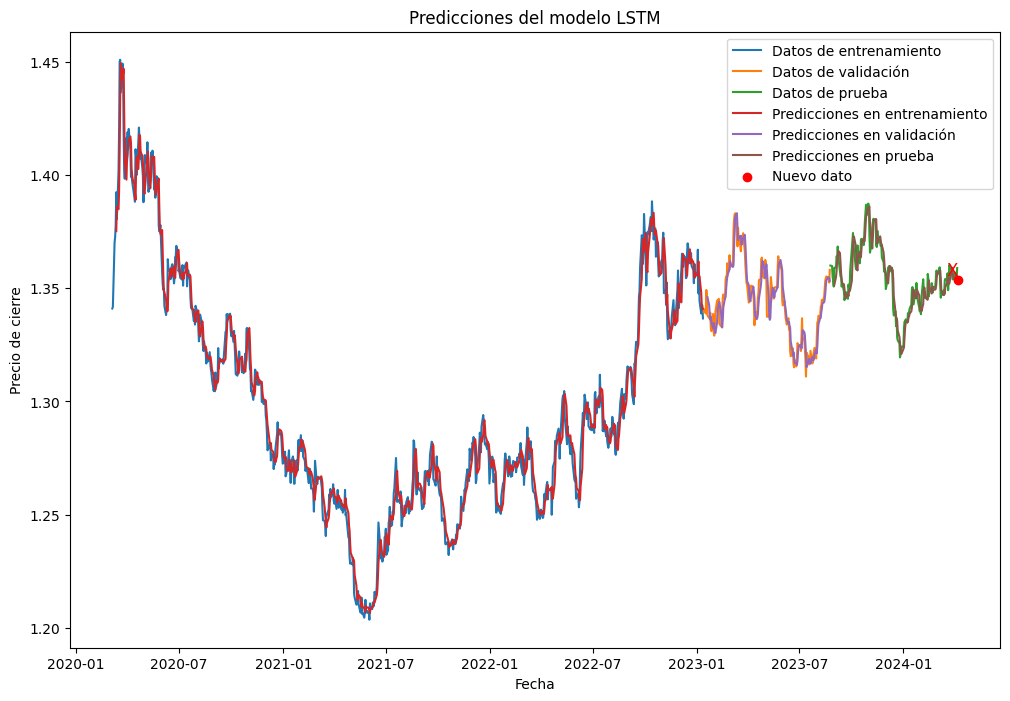

In [ ]:
# Graficar resultados
plt.figure(figsize=(12, 8))

# Datos de entrenamiento
plt.plot(data.index[:train_size], data['usdcad'][:train_size], label='Datos de entrenamiento')

# Datos de validación
plt.plot(data.index[train_size:train_size+val_size], data['usdcad'][train_size:train_size+val_size], label='Datos de validación')

# Datos de prueba
plt.plot(data.index[train_size+val_size:], data['usdcad'][train_size+val_size:], label='Datos de prueba')

# Predicciones en entrenamiento
plt.plot(data.index[seq_length:train_size], train_predictions, label='Predicciones en entrenamiento')

# Predicciones en validación
plt.plot(data.index[train_size+seq_length:train_size+val_size], val_predictions, label='Predicciones en validación')

# Predicciones en prueba
plt.plot(data.index[train_size+val_size+seq_length:], test_predictions, label='Predicciones en prueba')

# Añadir el nuevo dato para predicción
new_date = data.index[-1] + pd.DateOffset(days=1)
plt.scatter(new_date, test_predictions[-1], color='red', label='Nuevo dato', zorder=5)
plt.text(new_date, test_predictions[-1], 'X', color='red', fontsize=12, ha='right', va='bottom')

plt.title('Predicciones del modelo LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.show()

In [ ]:
# Crear un diccionario con los resultados de las métricas
results = {
    'Modelo': ['RNN', 'Feedforward NN', 'LSTM'],
    'MSE': [MSE_rnn, MSE_ff, MSE_lstm],
    'MAE': [MAE_rnn, MAE_ff, MAE_lstm],
    'MAPE': [MAPE_rnn, MAPE_ff, MAPE_lstm]
}

# Crear un DataFrame con los resultados
df_results = pd.DataFrame(results)

# Imprimir el DataFrame
print(df_results)

           Modelo       MSE       MAE      MAPE
0             RNN  0.000037  0.004583  0.347789
1  Feedforward NN  0.000160  0.009695  0.734885
2            LSTM  0.000046  0.005139  0.390335


**Predicción con Naive Bayes**

El modelo Naive Bayes es un clasificador probabilístico simple pero efectivo que se basa en el teorema de Bayes y asume independencia condicional entre las características. Aunque su simplicidad puede parecer una limitación, el modelo Naive Bayes ha demostrado su utilidad en una variedad de aplicaciones, incluido el análisis financiero.

A continuación exploraremos cómo el modelo Naive Bayes puede ser utilizado para calcular la volatilidad del CAD respecto al USD. Al aprovechar datos históricos, indicadores financieros y otros factores relevantes, el modelo Naive Bayes puede proporcionar estimaciones confiables de la volatilidad futura, ofreciendo así una perspectiva valiosa para los participantes del mercado financiero.

In [ ]:
# Obtener el último valor observado en el conjunto de entrenamiento
naive_prediction = y_train[-1]

# Replicar la predicción en los conjuntos de validación y prueba
naive_predictions_val = np.full_like(y_val, naive_prediction)
naive_predictions_test = np.full_like(y_test, naive_prediction)

# Calcular el Error Cuadrático Medio (MSE) para el conjunto de validación
MSE_naive_val = mean_squared_error(y_val, naive_predictions_val)

# Calcular el Error Cuadrático Medio (MSE) para el conjunto de prueba
MSE_naive_test = mean_squared_error(y_test, naive_predictions_test)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de validación
MAE_naive_val = mean_absolute_error(y_val, naive_predictions_val)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de prueba
MAE_naive_test = mean_absolute_error(y_test, naive_predictions_test)

# Calcular el Porcentaje Absoluto Medio de Error (MAPE) para el conjunto de validación
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE_naive_val = calculate_mape(y_val, naive_predictions_val)

# Calcular el Porcentaje Absoluto Medio de Error (MAPE) para el conjunto de prueba
MAPE_naive_test = calculate_mape(y_test, naive_predictions_test)

# Crear un DataFrame con los resultados
df_results_naive = pd.DataFrame({
    'Modelo': ['Naive'],
    'MSE': [MSE_naive_val],
    'MAE': [MAE_naive_val],
    'MAPE': [MAPE_naive_val]
})

# Imprimir el DataFrame
print(df_results_naive)

  Modelo       MSE       MAE      MAPE
0  Naive  0.000327  0.014716  1.089482


In [ ]:
# Crear un DataFrame con todos los resultados
df_all_results = pd.DataFrame({
    'Modelo': ['RNN', 'Feedforward NN', 'LSTM', 'Naive'],
    'MSE': [MSE_rnn, MSE_ff, MSE_lstm, MSE_naive_val],
    'MAE': [MAE_rnn, MAE_ff, MAE_lstm, MAE_naive_val],
    'MAPE': [MAPE_rnn, MAPE_ff, MAPE_lstm, MAPE_naive_val]
})

# Imprimir el DataFrame con todos los resultados
print(df_all_results)

           Modelo       MSE       MAE      MAPE
0             RNN  0.000037  0.004583  0.347789
1  Feedforward NN  0.000160  0.009695  0.734885
2            LSTM  0.000046  0.005139  0.390335
3           Naive  0.000327  0.014716  1.089482


**Conclusiones**

*   El modelo Feedforward ha obtenido un rendimiento ligeramente mejor que el modelo RNN. Esto se puede observar en la comparación de los valores de RMSE para los dos modelos, sin embargo al comparar los valores de MSE, MAE y MAPE para los cuatro modelos, podemos identificar el modelo con el mejor rendimiento general. En este caso, el Modelo RNN presenta los valores más bajos para las tres métricas:

MSE: 0.000037

MAE: 0.004583

MAPE: 0.347789

Esto sugiere que el Modelo RNN tiene el mejor ajuste a los datos y produce predicciones más precisas en comparación con los otros tres modelos.

*   Ambos modelos, RNN y Feedforward, han obtenido un buen rendimiento en la predicción de la volatilidad del CAD respecto al USD. Esto se puede observar en los valores de RMSE relativamente bajos para los tres conjuntos de datos.

*   El modelo RNN ha obtenido un mejor rendimiento en el conjunto de entrenamiento que el model FeedForward. Esto significa que el modelo RNN se ajusta mejor a los datos de entrenamiento que el modelo Feedforward.

*   Los modelos de redes neuronales muestran un mejor rendimiento que Naive Bayes, lo que nos muestra claramente que la modelación ayuda a obtener mejores predicciones para la volatilidad

